### Stock Chart Pattern Recognition 

4 Patterns
1. Double Top (DT)
2. Double Bottom (DB)
3. Head and Shoulders (HAS)
4. Reverse Head and Shoulders (RHAS)

In [364]:
import pandas as pd
import tensorflow as tf
import os
import datetime
import plotly.graph_objects as go
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

### Loading Data

In [56]:
# all 4 batches of stock data
df1 = pd.read_csv('SampleData.csv')
df2 = pd.read_csv('SampleData2.csv')
df3 = pd.read_csv('SampleData3.csv')
df4 = pd.read_csv('SampleData4.csv')
testdf = pd.read_csv('TestData.csv')

In [57]:
# all 4 batches of pattern data which contains info. about when which pattern formed, patterni corresponds to dfi
pattern1 = pd.read_csv('SampleDataGT.csv')
pattern2 = pd.read_csv('SampleData2GT.csv')
pattern3 = pd.read_csv('SampleData3GT.csv')
pattern4 = pd.read_csv('SampleData4GT.csv')
# generate TestDataGT having same information as any GT file from TestData after training the model

In [78]:
print(df1.shape,pattern1.shape)
print(df2.shape,pattern2.shape)
print(df3.shape,pattern3.shape)
print(df4.shape,pattern4.shape)

(21586, 6) (90, 4)
(71967, 6) (295, 4)
(43183, 6) (185, 4)
(43178, 6) (195, 4)


In [80]:
df1.columns # unnamed one is an daily index of a stock in duration of 5 mins (72 segment, 0 to 71) some day may imbalance

Index(['Unnamed: 0', 'open', 'close', 'high', 'low', 'date'], dtype='object')

In [81]:
pattern1.columns

Index(['Unnamed: 0', 'start', 'end', 'pattern'], dtype='object')

### UNDERSTANDING DATA FIRST

In [58]:
df1

,Unnamed: 0,open,close,high,low,date
0,0,1032.144200,1032.246108,1038.520819,1025.869489,2020-01-02 09:00:00
1,1,1032.246108,1032.417499,1040.101487,1024.562120,2020-01-02 09:05:00
2,2,1032.417499,1032.375497,1040.023616,1024.769380,2020-01-02 09:10:00
3,3,1032.375497,1032.398605,1033.532570,1031.241532,2020-01-02 09:15:00
4,4,1032.398605,1032.482789,1037.506628,1027.374766,2020-01-02 09:20:00
...,...,...,...,...,...,...
21581,67,1672.852023,1678.324194,1681.038031,1670.138186,2021-02-24 14:35:00
21582,68,1678.324194,1677.952490,1687.895346,1668.381338,2021-02-24 14:40:00
21583,69,1677.952490,1676.963826,1689.028256,1665.888061,2021-02-24 14:45:00
21584,70,1676.963826,1679.059744,1688.330764,1667.692807,2021-02-24 14:50:00


In [84]:
pattern1

,Unnamed: 0,start,end,pattern
0,0,2020-01-08 10:50:00,2020-01-08 13:00:00,Reverse Head and shoulders
1,1,2020-01-09 10:40:00,2020-01-09 12:45:00,Head and shoulders
2,2,2020-01-15 12:45:00,2020-01-15 14:50:00,Head and shoulders
3,3,2020-01-16 11:00:00,2020-01-16 13:10:00,Reverse Head and shoulders
4,4,2020-01-20 12:05:00,2020-01-20 13:55:00,Head and shoulders
...,...,...,...,...
85,85,2021-02-09 12:50:00,2021-02-09 14:40:00,Head and shoulders
86,86,2021-02-10 12:20:00,2021-02-10 13:45:00,Double Bottom
87,87,2021-02-11 11:00:00,2021-02-11 12:50:00,Reverse Head and shoulders
88,88,2021-02-18 11:10:00,2021-02-18 13:20:00,Reverse Head and shoulders


### SOME IRREGULAR TRADE DAY (< 72 Info)

In [95]:
def irregularDay(dfx):
    check = dfx.to_numpy()
    count = 0
    i=0
    while(i<len(check)):
        for j in range(i+1,i+72):
            if(check[j][0]==0):
                print(j-i,end=" ")
                i+=(j-i)
                print(i)
                break
        else:
            i+=72
            count+=1
    print(count)

In [96]:
# df1
irregularDay(df1)

69 11805
61 12226
298


In [88]:
298*72 + 69 + 61 == len(df1) # except 2 days , every day has 72 stock data (starts at 9am and ends at 3pm)

True

In [98]:
# df2
irregularDay(df2)

67 2443
70 36209
70 37215
57 64488
63 64623
995


In [87]:
995*72 + 67 + 70 + 70 + 57 + 63 == len(df2) # 5 days

True

In [99]:
# df3
irregularDay(df3)

70 16342
57 16543
598


In [90]:
598*72 + 70 + 57 == len(df3) # 2 days

True

In [100]:
# df4
irregularDay(df4)

69 2157
61 18346
64 41450
597


In [93]:
597*72 + 69 + 61 + 64 == len(df4) # 3 days

True

# EDA / PATTERN VISUALIZATION USING PLOTLY

In [61]:
def draw_candlesticks(dfx,chart_title='',xaxis_rangeslider_visible=True,save=False,image='',show=True):
    figx = go.Figure(go.Candlestick(x=dfx['date'],
               open = dfx['open'],
               close = dfx['close'],
               high = dfx['high'],
               low = dfx['low']),
               go.Layout(title=chart_title)
            )
    figx.update_layout(xaxis_rangeslider_visible = xaxis_rangeslider_visible)
    if show:
        figx.show()
    if save:
        figx.write_image(os.path.join('StockImages',image),format='png')

In [83]:
dfa = df1.iloc[:72,:]
draw_candlesticks(dfa,'No Pattern',save=True,image='../dummy.png')

In [63]:
df1['date'].iloc[287:289]

287    2020-01-07 14:55:00
288    2020-01-08 09:00:00
Name: date, dtype: object

In [64]:
dfb = df1.iloc[288:288+72]
draw_candlesticks(dfb,'Reverse Head and Shoulder',xaxis_rangeslider_visible=False)

In [65]:
df1['date'].iloc[359:361]

359    2020-01-08 14:55:00
360    2020-01-09 09:00:00
Name: date, dtype: object

In [66]:
dfc = df1.iloc[360:360+72]
draw_candlesticks(dfc,'Head and Shoulder',xaxis_rangeslider_visible=False)

In [67]:
df1['date'].iloc[1079:1081]

1079    2020-01-22 14:55:00
1080    2020-01-23 09:00:00
Name: date, dtype: object

In [68]:
dfd = df1.iloc[1080:1080+72]
draw_candlesticks(dfd,'Double Top',xaxis_rangeslider_visible=False)

In [69]:
df1['date'].iloc[6839:6841]

6839    2020-05-13 14:55:00
6840    2020-05-14 09:00:00
Name: date, dtype: object

In [70]:
dfe = df1.iloc[6840:6840+72]
draw_candlesticks(dfe,'Double Bottom',xaxis_rangeslider_visible=False)

In [71]:
# to work with datetime module
print(datetime.datetime.strptime(df1['date'][0],'%Y-%m-%d %H:%M:%S'))
df_date = pd.to_datetime(df1['date']) # another way to convert
df_date[0] # df_date.dt.date gives date and df_date.dt.time gives time

2020-01-02 09:00:00


Timestamp('2020-01-02 09:00:00')

In [72]:
df1

,Unnamed: 0,open,close,high,low,date
0,0,1032.144200,1032.246108,1038.520819,1025.869489,2020-01-02 09:00:00
1,1,1032.246108,1032.417499,1040.101487,1024.562120,2020-01-02 09:05:00
2,2,1032.417499,1032.375497,1040.023616,1024.769380,2020-01-02 09:10:00
3,3,1032.375497,1032.398605,1033.532570,1031.241532,2020-01-02 09:15:00
4,4,1032.398605,1032.482789,1037.506628,1027.374766,2020-01-02 09:20:00
...,...,...,...,...,...,...
21581,67,1672.852023,1678.324194,1681.038031,1670.138186,2021-02-24 14:35:00
21582,68,1678.324194,1677.952490,1687.895346,1668.381338,2021-02-24 14:40:00
21583,69,1677.952490,1676.963826,1689.028256,1665.888061,2021-02-24 14:45:00
21584,70,1676.963826,1679.059744,1688.330764,1667.692807,2021-02-24 14:50:00


In [73]:
indx = df1.query("date == '2020-01-08 10:50:00' | date == '2020-01-08 13:00:00'").index
start,end = indx[0],indx[1]
print(start,end)
rhas = df1.iloc[start:end,:]
draw_candlesticks(rhas,'Only RHAS Portion',xaxis_rangeslider_visible=False)

310 336


# FUNCTION TO GET HIGHLIGHTED PORTION WHERE PATTERN IS FORMED

In [408]:
def highlightPattern(data:pd.DataFrame(),pattern:pd.DataFrame(),indx)->pd.DataFrame():
    """
        Data contains candlestick information, whereas pattern dataframe contains all pattern formed along with their time.
    """
    startTime,endTime = pattern['start'].iloc[indx],pattern['end'].iloc[indx]
    patternType = pattern['pattern'].iloc[indx]
    indx = data.query(f"date == '{startTime}' | date == '{endTime}'").index
    start,end = indx[0],indx[1]
    new_df = data.iloc[start:end,:]
    return new_df,patternType

In [409]:
a=len(pattern1);b=len(pattern2);c=len(pattern3);d=len(pattern4)
for i in range(a):
    dfx,ptype = highlightPattern(df1,pattern1,i)
    draw_candlesticks(dfx,ptype,xaxis_rangeslider_visible=False,save=True,image=f'{ptype}/image{i}.png',show=False)

for j in range(b):
    dfx,ptype = highlightPattern(df2,pattern2,j)
    draw_candlesticks(dfx,ptype,xaxis_rangeslider_visible=False,save=True,image=f'{ptype}/image{j+a}.png',show=False)

for k in range(c):
    dfx,ptype = highlightPattern(df3,pattern3,k)
    draw_candlesticks(dfx,ptype,xaxis_rangeslider_visible=False,save=True,image=f'{ptype}/image{k+a+b}.png',show=False)

for l in range(d):
    dfx,ptype = highlightPattern(df4,pattern4,l)
    draw_candlesticks(dfx,ptype,xaxis_rangeslider_visible=False,save=True,image=f'{ptype}/image{l+a+b+c}.png',show=False)

All Images are of 500 X 700 X 3

In [268]:
img = cv2.imread('StockImages/Double Bottom/image12.png')
print(img.shape)
img = img[100:420,80:620] # 320 * 540

cv2.imshow('image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

(500, 700, 3)


In [269]:
img.shape

(320, 540, 3)

In [270]:
import math
320/5,540/5

(64.0, 108.0)

In [271]:
res_img = cv2.resize(img,(108,64))
cv2.imshow('image',res_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [272]:
res_img.shape

(64, 108, 3)

# PROCESSING THE IMAGE (RESHAPING, RESIZING AND RGB2GRAY)
to reduce space and unnecssary details

In [486]:
def convertGreyScale(path):
    """
        Converts RGB image to grey scale image
    """
    img = cv2.imread(path)
    grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    cv2.imwrite(path,grey)

In [442]:
path = os.path.join('dummy.png')
convertGreyScale(path)

In [487]:
def processImage(img,savepath):
    """ 
        Reshape and Resize the image
    """
    if(img.shape!=(500, 700, 3)):
        return
    img = img[100:420,80:620]
    res_img = cv2.resize(img,(108,64))
    grey = cv2.cvtColor(res_img,cv2.COLOR_BGR2GRAY)
    cv2.imwrite(savepath,grey)

In [411]:
folder = 'StockImages'
imagedir = os.listdir(folder)
print(imagedir)

['Double Bottom', 'Double Top', 'Head and shoulders', 'No Pattern', 'No Pattern Compressed', 'Reverse Head and shoulders']


In [412]:
for file1 in imagedir:
    for file2 in os.listdir(os.path.join(folder,file1)):
        img = cv2.imread(os.path.join(folder,file1,file2))
        processImage(img,os.path.join('StockImages',file1,file2))

### CREATING NO PATTERN DUMMY DATA

In [309]:
pd.to_datetime(df1['date'].iloc[0]).date()==pd.to_datetime(df1['date'].iloc[71]).date()

True

In [488]:
## getting no pattern data
def createdummy(start,end,data):
    """
        Create Data between Start and end in dataframe
    """
    new_df = data.iloc[start:end]
    return new_df

In [489]:
def randomData(data:pd.DataFrame(),pattern:pd.DataFrame(),hrs,indx):
    """
        Generates Random data for hours hrs specified 
    """
    jump = hrs*60//5
    n = len(data)
    for i in range(0,n-jump,jump):
        dfx=createdummy(i,i+jump,data) # 3hr data
        pattdf = pattern.query(f"start=='{dfx['date'].iloc[0]}' | end=='{dfx['date'].iloc[jump-1]}'")
        if(len(pattdf)==0 and pd.to_datetime(dfx['date'].iloc[0]).date()==pd.to_datetime(dfx['date'].iloc[jump-1]).date()):
            draw_candlesticks(dfx,'No Pattern',xaxis_rangeslider_visible=False,save=True,image=f'No Pattern/image{i+indx}.png',show=False)

In [317]:
indx = 0
randomData(df1,pattern1,3,indx)

In [318]:
indx += len(df1)
randomData(df2,pattern2,3,indx)

In [320]:
indx += len(df2) 
randomData(df3,pattern3,3,indx)

In [321]:
indx += len(df3) 
randomData(df4,pattern4,3,indx)

In [415]:
## preprocess the data
len(os.listdir(os.path.join('StockImages','No Pattern')))

2922

In [416]:
path = os.path.join('StockImages','No Pattern')
print(path)

StockImages\No Pattern


In [324]:
for image in os.listdir(path):
    img = cv2.imread(os.path.join(path,image))
    processImage(img,os.path.join(path,image))

In [420]:
# since data is too large, only keeping random 1200 images of no pattern
import shutil
src = os.path.join('StockImages','No Pattern')
dest = os.path.join('StockImages','No Pattern Compressed')

images = os.listdir(src)
print(len(images))
collect = random.sample(images,1200)
print(len(collect))
for files in collect:
    shutil.copyfile(os.path.join(src,files),os.path.join(dest,files))

2922
1200


# CREATING DATA CAPABLE OF TRAINING

In [421]:
pattern_val = {0:'No Pattern',1:'Double Bottom',2:'Double Top',3:'Head and Shoulders',4:'Reverse Head and Shoulders'}
pattern_val

{0: 'No Pattern',
 1: 'Double Bottom',
 2: 'Double Top',
 3: 'Head and Shoulders',
 4: 'Reverse Head and Shoulders'}

In [422]:
X = []
y = []
path0 = os.path.join('StockImages','No Pattern')
path1 = os.path.join('StockImages','Double Bottom')
path2 = os.path.join('StockImages','Double Top')
path3 = os.path.join('StockImages','Head and Shoulders')
path4 = os.path.join('StockImages','Reverse Head and Shoulders')

for i in os.listdir(path0):
    img = cv2.imread(os.path.join(path0,i))
    X.append(img)
    y.append(0)

for i in os.listdir(path1):
    img = cv2.imread(os.path.join(path1,i))
    X.append(img)
    y.append(1)

for i in os.listdir(path2):
    img = cv2.imread(os.path.join(path2,i))
    X.append(img)
    y.append(2)

for i in os.listdir(path3):
    img = cv2.imread(os.path.join(path3,i))
    X.append(img)
    y.append(3)

for i in os.listdir(path4):
    img = cv2.imread(os.path.join(path4,i))
    X.append(img)
    y.append(4)

In [448]:
X = np.array(X)
y = np.array(y)

In [452]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)

In [453]:
# 3687 pattern images of size 64 X 108 (RGB) 
print(X.shape)
print(y.shape)

(3687, 64, 108, 3)
(3687, 5)


In [454]:
# shuffle the array
shuff = np.random.permutation(X.shape[0])
X = X[shuff]
y = y[shuff]
shuff = np.random.permutation(X.shape[0])
X = X[shuff]
y = y[shuff]

In [455]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=40,test_size=0.25,stratify=y)

In [456]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(2765, 64, 108, 3)
(2765, 5)
(922, 64, 108, 3)
(922, 5)


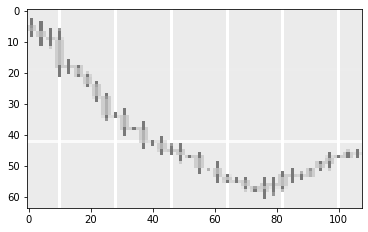

In [438]:
plt.imshow(X_train[0])

### PREPROCESSING DATA -> NORMALIZE /255

In [457]:
X_train=X_train/255
X_test=X_test/255

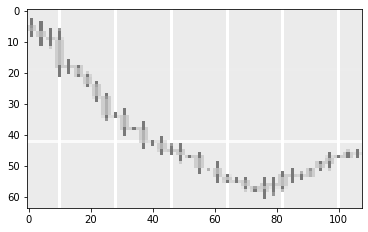

In [440]:
plt.imshow(X_train[0])

# CNN ARCHITECTURE

In [460]:
from keras.models import Sequential,Model
from keras.layers import Dense,Flatten

In [459]:
from keras.applications import vgg16

vgg = vgg16.VGG16(input_shape=(64,108,3),weights='imagenet',include_top=False) # it is trained for 1000 class classification task hence, removing output layer

# don't let the model to train weights, it is already trained
for layer in vgg.layers:
    layer.trainable = False

58900480/58889256 [==============================] - 78s 1us/step


In [461]:
flat = Flatten()(vgg.output)

final = Dense(5,activation='softmax')(flat)

model = Model(inputs=vgg.input,outputs=final)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 108, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 108, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 108, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 54, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 54, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 54, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 27, 128)       0     

In [462]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [464]:
model.fit(X_train,y_train,epochs=20,validation_data=(X_test,y_test),verbose=1)

Epoch 1/20
87/87 [==============================] - 97s 1s/step - loss: 0.3231 - accuracy: 0.9081 - val_loss: 0.1569 - val_accuracy: 0.9696
Epoch 2/20
87/87 [==============================] - 106s 1s/step - loss: 0.1018 - accuracy: 0.9928 - val_loss: 0.0790 - val_accuracy: 0.9967
Epoch 3/20
87/87 [==============================] - 103s 1s/step - loss: 0.0585 - accuracy: 0.9967 - val_loss: 0.0538 - val_accuracy: 0.9989
Epoch 4/20
87/87 [==============================] - 101s 1s/step - loss: 0.0397 - accuracy: 0.9982 - val_loss: 0.0391 - val_accuracy: 1.0000
Epoch 5/20
87/87 [==============================] - 104s 1s/step - loss: 0.0298 - accuracy: 0.9989 - val_loss: 0.0321 - val_accuracy: 0.9967
Epoch 6/20
87/87 [==============================] - 102s 1s/step - loss: 0.0240 - accuracy: 0.9986 - val_loss: 0.0268 - val_accuracy: 0.9978
Epoch 7/20
87/87 [==============================] - 101s 1s/step - loss: 0.0199 - accuracy: 0.9989 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 8/20
87/

In [465]:
score = model.evaluate(X_test,y_test)
print(f'Loss : {score[0]} , Accuracy : {score[1]}')

29/29 [==============================] - 26s 907ms/step - loss: 0.0060 - accuracy: 1.0000
Loss : 0.005959427449852228 , Accuracy : 1.0


In [503]:
X_test[0].shape

(64, 108, 3)

In [506]:
val = model.predict(X_test)

In [466]:
model.save('model_vgg16.h5')

### PREDICTION -> DIRECT FUNCTION AT LAST

In [468]:
testdf

,Unnamed: 0,open,close,low,high,date
0,0,1541.130000,1547.777449,1536.242463,1552.664986,2020-01-02 09:00:00
1,1,1547.777449,1550.119675,1535.531174,1562.365950,2020-01-02 09:05:00
2,2,1550.119675,1555.196241,1541.053843,1564.262073,2020-01-02 09:10:00
3,3,1555.196241,1562.850000,1547.670809,1570.375432,2020-01-02 09:15:00
4,4,1562.850000,1565.715472,1557.312400,1571.253072,2020-01-02 09:20:00
...,...,...,...,...,...,...
21590,67,29292.257173,29752.035126,29130.933279,29913.359020,2021-02-24 14:35:00
21591,68,29752.035126,29539.941461,29534.733980,29757.242607,2021-02-24 14:40:00
21592,69,29539.941461,29599.132840,29539.576870,29599.497431,2021-02-24 14:45:00
21593,70,29599.132840,29849.730754,29436.477258,30012.386336,2021-02-24 14:50:00


In [469]:
irregularDay(testdf)

67 2083
299


In [602]:
2083-67

2016

In [483]:
testdf.iloc[2016:2016+67]

,Unnamed: 0,open,close,low,high,date
2016,0,2975.886292,2979.978816,2968.479283,2987.385826,2020-02-11 09:00:00
2017,1,2979.978816,2997.374906,2979.514290,2997.839432,2020-02-11 09:05:00
2018,2,2997.374906,2988.254034,2967.229103,3018.399838,2020-02-11 09:10:00
2019,3,2988.254034,3004.272208,2977.901244,3014.624998,2020-02-11 09:15:00
2020,4,3004.272208,3008.693858,2984.304753,3028.661313,2020-02-11 09:20:00
...,...,...,...,...,...,...
2078,62,3057.005806,3054.278124,3052.025951,3059.257978,2020-02-11 14:10:00
2079,63,3054.278124,3051.842491,3028.531474,3077.589141,2020-02-11 14:15:00
2080,64,3051.842491,3054.089149,3050.707140,3055.224501,2020-02-11 14:20:00
2081,65,3054.089149,3050.062847,3038.412839,3065.739157,2020-02-11 14:25:00


In [607]:
def iregularDay(dfx):
        irr = []
        check = dfx.to_numpy()
        count = 0
        i=0
        while(i<len(check)):
            for j in range(i+1,i+72):
                if(check[j][0]==0):
                    v1 = j-i
                    i+=(j-i)
                    v2 = i - v1
                    irr.append((v1,v2))
                    break
            else:
                i+=72
                count+=1
        return irr

iregularDay(testdf)

[(67, 2016)]

In [516]:
n = len(testdf)
i=0
dates = []

while(i<n-71):

    if(i==2016):

        date = pd.to_datetime(testdf['date'].iloc[i]).date()
        dates.append(date)
        dfx = testdf.iloc[i:i+67]

        draw_candlesticks(dfx,'',xaxis_rangeslider_visible=False,save=True,image=os.path.join('Test Image',f'image{i}.png'),show=False)

        i+=67
    else:

        date = pd.to_datetime(testdf['date'].iloc[i]).date()
        dates.append(date)
        dfx = testdf.iloc[i:i+72]

        draw_candlesticks(dfx,'',xaxis_rangeslider_visible=False,save=True,image=os.path.join('Test Image',f'image{i}.png'),show=False)
        
        i+=72

In [517]:
path = os.path.join('StockImages','Test Image')
for image in os.listdir(path):
    img = cv2.imread(os.path.join(path,image))
    processImage(img,os.path.join(path,image))

In [518]:
X_input = []
path = os.path.join('StockImages','Test Image')
for image in os.listdir(path):
    img = cv2.imread(os.path.join(path,image))
    X_input.append(img)
X_input = np.array(X_input)

In [519]:
X_input.shape

(300, 64, 108, 3)

In [529]:
X_input = X_input/255

In [629]:
patterns = model.predict(X_input)

In [541]:
pattern_val

{0: 'No Pattern',
 1: 'Double Bottom',
 2: 'Double Top',
 3: 'Head and Shoulders',
 4: 'Reverse Head and Shoulders'}

In [621]:
## it decides the winner
def decideWinner(patterns,indx):
    avg = patterns.mean(axis=0)
    val = patterns[indx]

    mask = val>avg
    pos = abs(avg-val)

    maxi = -1000
    idx = 0
    for i in range(len(mask)):
        if(mask[i] and pos[i]>maxi):
            maxi=pos[i]
            idx=i
    return idx

In [630]:
answer = np.array([pattern_val[decideWinner(patterns,i)] for i in range(len(patterns))])
testGT = pd.DataFrame({'date':dates,'pattern':answer})
testGT

,date,pattern
0,2020-01-02,Double Bottom
1,2020-01-03,Double Top
2,2020-01-06,Double Bottom
3,2020-01-07,Double Bottom
4,2020-01-08,No Pattern
...,...,...
295,2021-02-18,Double Bottom
296,2021-02-19,Double Bottom
297,2021-02-22,Double Bottom
298,2021-02-23,No Pattern


# TAKES ANY CANDLESTICK DATA FILE AND PRODUCES OUTPUT FILE
the limitation is this can not tell the start and end time of the pattern as it uses CNN

In [636]:
from keras.models import load_model
def predictPattern(input_file,save_file,dir='./')->pd.DataFrame(): # dir for storing image files
    """
    It converts any given input candlestick data file to predicted pattern data
    """
    df = pd.read_csv(input_file)
    n = len(df)
    i=0
    dates = []

    # filtering out the odd dates
    def iregularDay(dfx):
        irr = []
        check = dfx.to_numpy()
        count = 0
        i=0
        while(i<len(check)):
            for j in range(i+1,i+72):
                if(check[j][0]==0):
                    v1 = j-i
                    i+=(j-i)
                    v2 = i - v1
                    irr.append((v1,v2))
                    break
            else:
                i+=72
                count+=1
        return irr

    irr = iregularDay(df)
    ind = 0
    while(i<n-71):

        if(ind<len(irr) and i==irr[ind][1]):
            date = pd.to_datetime(df['date'].iloc[i]).date()
            dates.append(date)
            dfx = df.iloc[i:i+irr[ind][0]]

            draw_candlesticks(dfx,'',xaxis_rangeslider_visible=False,save=True,image=os.path.join(dir,f'image{i}.png'),show=False)

            i+=irr[ind][0]
            ind+=1
        else:

            date = pd.to_datetime(df['date'].iloc[i]).date()
            dates.append(date)
            dfx = df.iloc[i:i+72]

            draw_candlesticks(dfx,'',xaxis_rangeslider_visible=False,save=True,image=os.path.join(dir,f'image{i}.png'),show=False)

            i+=72

    # preprocessing images

    path = os.path.join('StockImages',dir)
    for image in os.listdir(path):
        img = cv2.imread(os.path.join(path,image))
        processImage(img,os.path.join(path,image))

    # test data creation
    
    X_input = []
    path = os.path.join('StockImages',dir)
    for image in os.listdir(path):
        img = cv2.imread(os.path.join(path,image))
        X_input.append(img)
    X_input = np.array(X_input)

    # normalizing

    X_input = X_input/255

    # prediction
    model = load_model('model_vgg16.h5')

    pattern_val = {0:'No Pattern',1:'Double Bottom',2:'Double Top',3:'Head and Shoulders',4:'Reverse Head and Shoulders'}
    patterns = model.predict(X_input)

    ## it decides the winner

    def decideWinner(patterns,indx):
        avg = patterns.mean(axis=0)
        val = patterns[indx]

        mask = val>avg

        pos = abs(avg-val)

        maxi = -1000
        idx = 0
        for i in range(5):
            if(mask[i] and pos[i]>maxi):
                maxi=pos[i]
                idx=i
        return idx
    
    answer = np.array([pattern_val[decideWinner(patterns,i)] for i in range(len(patterns))])
    testGT = pd.DataFrame({'date':dates,'pattern':answer})
    testGT.to_csv(save_file)
    return testGT
    

In [637]:
predictPattern(input_file='TestData.csv',save_file='TestDataGT.csv',dir = os.path.join('Test Image'))

,date,pattern
0,2020-01-02,No Pattern
1,2020-01-03,No Pattern
2,2020-01-06,Head and Shoulders
3,2020-01-07,No Pattern
4,2020-01-08,No Pattern
...,...,...
295,2021-02-18,No Pattern
296,2021-02-19,Double Top
297,2021-02-22,No Pattern
298,2021-02-23,Reverse Head and Shoulders
